<a href="https://colab.research.google.com/github/Sahab00/Movie-Recommendation-System-Description/blob/main/code_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Movie Recommendation System
Description**

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics.pairwise import cosine_similarity
import os


In [40]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset (1).zip


In [41]:
import zipfile
import os

# Path to your zip file
zip_path = "dataset.zip"
extract_to = "dataset"

# Unzip it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extraction done.")


✅ Extraction done.


In [42]:
ratings_path = "dataset/ml-100k/u.data"
movies_path = "dataset/ml-100k/u.item"

# Confirm files exist
print("Ratings file found:", os.path.exists(ratings_path))
print("Movies file found:", os.path.exists(movies_path))

Ratings file found: True
Movies file found: True


In [43]:
import os

print(os.listdir("dataset/ml-100k"))  # should list u.data, u.item, etc.


['u5.test', 'u4.base', 'u1.base', 'u1.test', 'u3.base', 'u4.test', 'u.genre', 'u.data', 'u3.test', 'ua.base', 'u2.test', 'u.user', 'u.occupation', 'ub.test', 'mku.sh', 'u.info', 'u.item', 'allbut.pl', 'README', 'ua.test', 'ub.base', 'u2.base', 'u5.base']


In [44]:

ratings_columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_path, sep='\t', names=ratings_columns)


movie_columns = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(movies_path, sep='|', names=movie_columns, encoding='latin-1', usecols=[0, 1])

user_item_matrix = ratings.pivot_table(index='user_id', columns='item_id', values='rating')
user_item_matrix.fillna(0, inplace=True)

user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

**Recommendation function**

In [45]:
def recommend_movies(user_id, user_item_matrix, similarity_df, movies_df, top_n=5):
    sim_scores = similarity_df[user_id]
    sim_scores[user_id] = 0

    weighted_ratings = sim_scores @ user_item_matrix
    sim_sums = sim_scores.sum()
    recommendation_scores = weighted_ratings / sim_sums

    watched = user_item_matrix.loc[user_id]
    watched = watched[watched > 0].index
    recommendation_scores = recommendation_scores.drop(watched, errors='ignore')

    top_items = recommendation_scores.sort_values(ascending=False).head(top_n).index
    return movies_df[movies_df['item_id'].isin(top_items)]




**Test recommendation for user 10**

In [46]:

recommended = recommend_movies(10, user_item_matrix, user_similarity_df, movies, top_n=5)
print("\nTop 5 Recommendations for User 10:")
print(recommended)


Top 5 Recommendations for User 10:
     item_id                            title
78        79             Fugitive, The (1993)
171      172  Empire Strikes Back, The (1980)
180      181        Return of the Jedi (1983)
203      204        Back to the Future (1985)
317      318          Schindler's List (1993)


**Precision@K**

In [47]:
from sklearn.model_selection import train_test_split

def precision_at_k(user_id, k, user_item_matrix, similarity_df, ratings_df):

    user_ratings = ratings_df[ratings_df['user_id'] == user_id]

    if len(user_ratings) < 5:
        return None

    train, test = train_test_split(user_ratings, test_size=0.4, random_state=42)
    train_matrix = user_item_matrix.copy()
    train_matrix.loc[user_id, train_matrix.columns] = 0
    train_matrix.loc[user_id, train['item_id']] = train['rating']

    sim_scores = similarity_df[user_id]
    sim_scores[user_id] = 0
    weighted_ratings = sim_scores @ train_matrix
    sim_sums = sim_scores.sum()
    recommendation_scores = weighted_ratings / sim_sums


    watched = train['item_id']
    recommendation_scores = recommendation_scores.drop(watched, errors='ignore')

    top_k = recommendation_scores.sort_values(ascending=False).head(k).index


    relevant_items = set(test['item_id'])

    hits = sum([1 for item in top_k if item in relevant_items])
    precision = hits / k

    return precision
score = precision_at_k(user_id=10, k=5, user_item_matrix=user_item_matrix, similarity_df=user_similarity_df, ratings_df=ratings)
print(f"Precision@5 for User 10: {score:.2f}")



Precision@5 for User 10: 0.40


**SVD-based Recommendations**

In [48]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=20, random_state=42)
matrix_svd = svd.fit_transform(user_item_matrix)

latent_similarity = cosine_similarity(matrix_svd)
latent_similarity_df = pd.DataFrame(latent_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)


svd_recommendations = recommend_movies(10, user_item_matrix, latent_similarity_df, movies, top_n=5)
print("\nTop 5 SVD-Based Recommendations for User 10:")
print(svd_recommendations)



Top 5 SVD-Based Recommendations for User 10:
     item_id                            title
171      172  Empire Strikes Back, The (1980)
172      173       Princess Bride, The (1987)
180      181        Return of the Jedi (1983)
203      204        Back to the Future (1985)
317      318          Schindler's List (1993)


In [49]:
def precision_at_k_for_method(user_id, k, user_item_matrix, similarity_df, ratings_df, recommend_func):

    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    if len(user_ratings) < 5:
        return None

    train, test = train_test_split(user_ratings, test_size=0.4, random_state=42)


    train_matrix = user_item_matrix.copy()
    train_matrix.loc[user_id, train_matrix.columns] = 0
    train_matrix.loc[user_id, train['item_id']] = train['rating']


    recommended_movies = recommend_func(user_id, train_matrix, similarity_df, movies, top_n=k)


    recommended_items = set(recommended_movies['item_id'])
    relevant_items = set(test['item_id'])
    hits = len(recommended_items.intersection(relevant_items))

    return hits / k


In [50]:
def user_based_recommend(user_id, user_item_matrix, similarity_df, movies_df, top_n=5):
    return recommend_movies(user_id, user_item_matrix, similarity_df, movies_df, top_n)

def svd_based_recommend(user_id, user_item_matrix, similarity_df, movies_df, top_n=5):
    return recommend_movies(user_id, user_item_matrix, similarity_df, movies_df, top_n)


In [51]:
users = user_item_matrix.index.tolist()
methods = {
    "User-Based": (user_based_recommend, user_similarity_df),
    "SVD-Based": (svd_based_recommend, latent_similarity_df)
}

results = {name: [] for name in methods.keys()}

for user_id in users:
    for method_name, (rec_func, sim_df) in methods.items():
        score = precision_at_k_for_method(user_id, 5, user_item_matrix, sim_df, ratings, rec_func)
        if score is not None:
            results[method_name].append(score)


for method_name, scores in results.items():
    avg_score = sum(scores) / len(scores) if scores else 0
    print(f"{method_name} Average Precision@5: {avg_score:.4f}")


User-Based Average Precision@5: 0.5236
SVD-Based Average Precision@5: 0.5084


**Displaying**

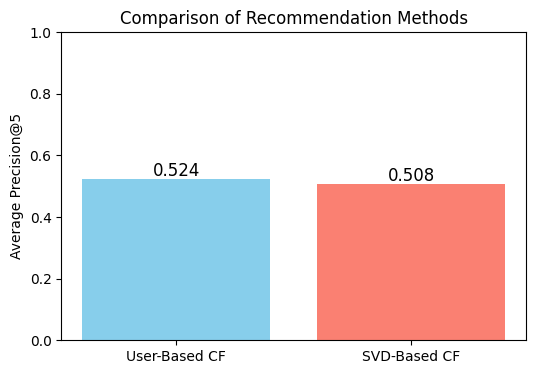

In [52]:
models = ['User-Based CF', 'SVD-Based CF']


precision_scores = [0.5236, 0.5084]

# Plotting
plt.figure(figsize=(6,4))
bars = plt.bar(models, precision_scores, color=['skyblue', 'salmon'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha='center', fontsize=12)

plt.ylim(0, 1)
plt.ylabel('Average Precision@5')
plt.title('Comparison of Recommendation Methods')
plt.show()
